### Optuna for LSTM

* Goal: determine best hyperparameters using Optuna optimization
* Split data as train/test 75/25
* Test with 10 trials and return best parameters

In [ ]:
#pip install optuna

In [ ]:
#############################################
######       LSTM Regressor Optuna     ######
#############################################

#######################
###### Libraries ######

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import optuna
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError
from scikeras.wrappers import KerasRegressor
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping

#######################
#####   Dataset   #####

bitcoin = pd.read_csv('BTC_cleaned.csv')
data = bitcoin
data.drop(columns=['Crypto', 'Open', 'High', 'Low', 'Log_Returns', 'Volatility'], inplace=True)

#######################
### Train/test set  ###
#######################

def sequence(data, window_size, max_samples=None):

    data = data.values
    x = []

    #Price on next day
    y = []

    window = window_size

    for i in range(window, max_samples):
        x_ = np.reshape(data[i-window:i, 0], (window, 1))
        x.append(x_)
        y.append(data[i, 0])

    return np.array(x), np.array(y)

# Create Windowed sequences
x_train, y_train = sequence(data, window_size=120, max_samples=900)
x_test, y_test = sequence(data[1021:1442], window_size=120, max_samples=300)


#######################
##### Optuna LSTM #####

def objective(trial):
    # Hyperparameters to optimize
    units1 = trial.suggest_categorical('units1', [18, 32, 64])
    units2 = trial.suggest_categorical('units2', [8, 16, 32])
    units3 = trial.suggest_categorical('units3', [2, 4])
    act_func = trial.suggest_categorical('act_func', ['relu', 'tanh', 'sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    epochs = trial.suggest_int('epochs', 50, 200, step=50)

    # Build model
    model = Sequential()
    model.add(LSTM(units1, return_sequences=True, activation=act_func, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(units2, return_sequences=True, activation=act_func))
    model.add(LSTM(units3, return_sequences=False, activation=act_func))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae', RootMeanSquaredError(), 'mape'])

    #for early stopping and pruning
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')]
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Output
print("Best trial:")
trial = study.best_trial

print(f"  Loss: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2025-07-28 02:09:34,500] A new study created in memory with name: no-name-962e5e59-bad8-4c97-b7ca-4dae451edd22
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-07-28 02:13:22,530] Trial 0 finished with value: 0.0009152329294010997 and parameters: {'units1': 32, 'units2': 16, 'units3': 2, 'act_func': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'epochs': 150}. Best is trial 0 with value: 0.0009152329294010997.
[I 2025-07-28 02:18:42,668] Trial 1 finished with value: 0.0009391782805323601 and parameters: {'units1': 32, 'units2': 8, 'units3': 2, 'act_func': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'epochs': 100}. Best is trial 0 with value: 0.0009152329294010997.
[I 2025-07-28 02:31:23,653] Trial 2 finished with value: 0.000144451

Best trial:
  Loss: 0.00010021569323725998
  Params:
    units1: 64
    units2: 16
    units3: 2
    act_func: tanh
    optimizer: adam
    batch_size: 32
    epochs: 50


In [ ]:
results = study.trials_dataframe()
results.head()
results.to_csv('optunalstm_results.csv', index=False)

* Validation/Prediction

In [ ]:
data = pd.read_csv('BTC_noscale.csv')
data.drop(columns=['Crypto', 'Open', 'High', 'Low'], inplace=True)
data.head()

,Date,Close
0,2018-01-01,13535.0
1,2018-01-02,14770.0
2,2018-01-03,15057.0
3,2018-01-04,14921.0
4,2018-01-05,16828.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values.reshape(-1, 1))
data_scaled = pd.concat([data[['Date']].reset_index(drop=True), pd.DataFrame(scaled_data, columns=['Close'])],axis=1)
data_scaled.head()

,Date,Close
0,2018-01-01,0.160136
1,2018-01-02,0.179249
2,2018-01-03,0.183691
3,2018-01-04,0.181586
4,2018-01-05,0.211100


In [ ]:
def sequence(data, window_size, max_samples=None):

    #data = data.values
    x = []

    #Price on next day
    y = []

    window = window_size

    for i in range(window, max_samples):
        x_ = np.reshape(data[i-window:i, 0], (window, 1))
        x.append(x_)
        y.append(data[i, 0])

    return np.array(x), np.array(y)

# Create Windowed sequences
x_train, y_train = sequence(scaled_data, window_size=120, max_samples=1300)
x_test, y_test = sequence(scaled_data[1421:], window_size=120, max_samples=434)

y_train.shape
x_train.shape

(1180, 120, 1)

In [ ]:
# Parameters
act_func = 'tanh'
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]

# LSTM model 10-5-2 units (3 layers)
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(n_timesteps,n_features), return_sequences=True, activation=act_func))
#lstm.add(Dropout(0.25))
lstm.add(LSTM(16, return_sequences=True, activation=act_func))
lstm.add(LSTM(2, return_sequences=False, activation=act_func))

# Softmax layer
lstm.add(Dense(1, activation='linear'))

# Loss is cross-entropy
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', RootMeanSquaredError(), 'mape'])

# Train LSTM
history = lstm.fit(x_train, y_train,
                   epochs=100, batch_size=32,
                   verbose=2)


y_predict= lstm.predict(x_test)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
37/37 - 75s - 2s/step - loss: 0.0235 - mae: 0.0958 - mape: 14386.9033 - root_mean_squared_error: 0.1534
Epoch 2/100
37/37 - 23s - 634ms/step - loss: 0.0028 - mae: 0.0324 - mape: 7239.9238 - root_mean_squared_error: 0.0526
Epoch 3/100
37/37 - 36s - 969ms/step - loss: 0.0020 - mae: 0.0249 - mape: 13905.7656 - root_mean_squared_error: 0.0448
Epoch 4/100
37/37 - 21s - 572ms/step - loss: 0.0017 - mae: 0.0235 - mape: 13361.6318 - root_mean_squared_error: 0.0412
Epoch 5/100
37/37 - 35s - 956ms/step - loss: 0.0017 - mae: 0.0234 - mape: 3038.1128 - root_mean_squared_error: 0.0407
Epoch 6/100
37/37 - 29s - 787ms/step - loss: 0.0016 - mae: 0.0232 - mape: 20271.5176 - root_mean_squared_error: 0.0404
Epoch 7/100
37/37 - 41s - 1s/step - loss: 0.0016 - mae: 0.0226 - mape: 9012.7939 - root_mean_squared_error: 0.0396
Epoch 8/100
37/37 - 24s - 647ms/step - loss: 0.0017 - mae: 0.0246 - mape: 2425.7358 - root_mean_squared_error: 0.0418
Epoch 9/100
37/37 - 38s - 1s/step - loss: 0.0015 - mae: 0.

* Plot results

MSE/MAE/MAPE

Prediction Plot


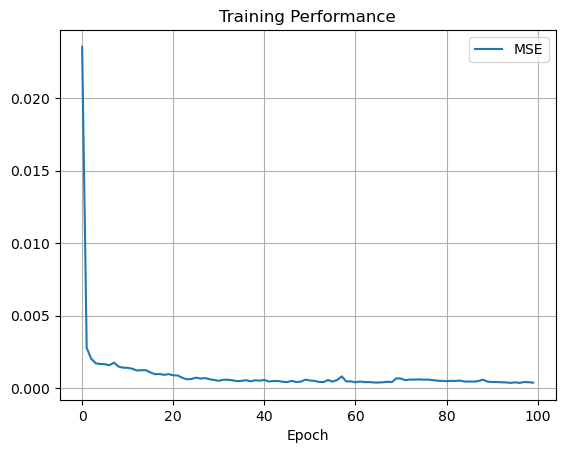

In [ ]:
# Plot Training MSE, MAE, MAPE, RMSE
plt.plot(history.history['loss'], label='MSE')
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

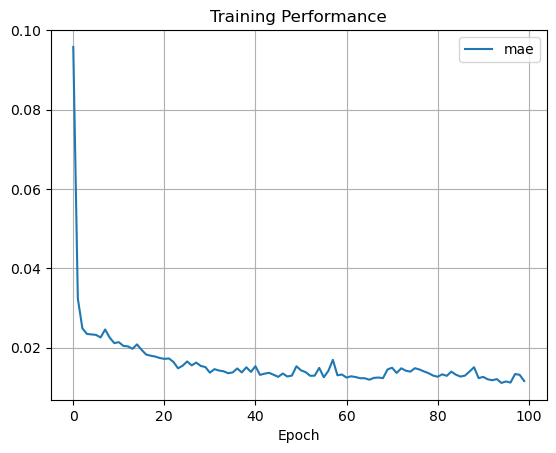

In [ ]:
plt.plot(history.history['mae'], label='mae')
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# plt.plot(history.history['mape'], label='mape')
# plt.title('Training Performance')
# plt.xlabel('Epoch')
# plt.legend()
# plt.grid(True)
# plt.show()

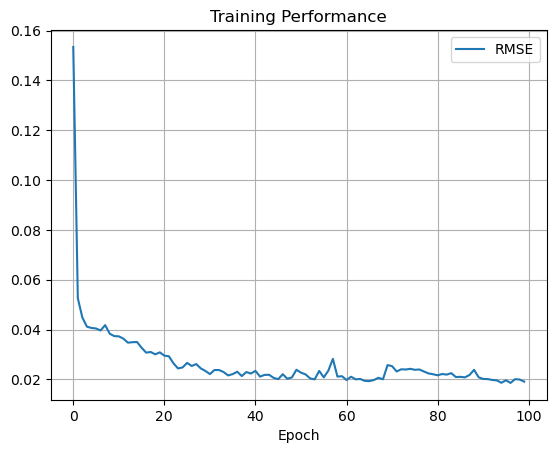

In [ ]:
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Training Performance')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Plot prediction
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
y_predict_orig = scaler.inverse_transform(y_predict)

In [ ]:
y_test.shape

(314,)

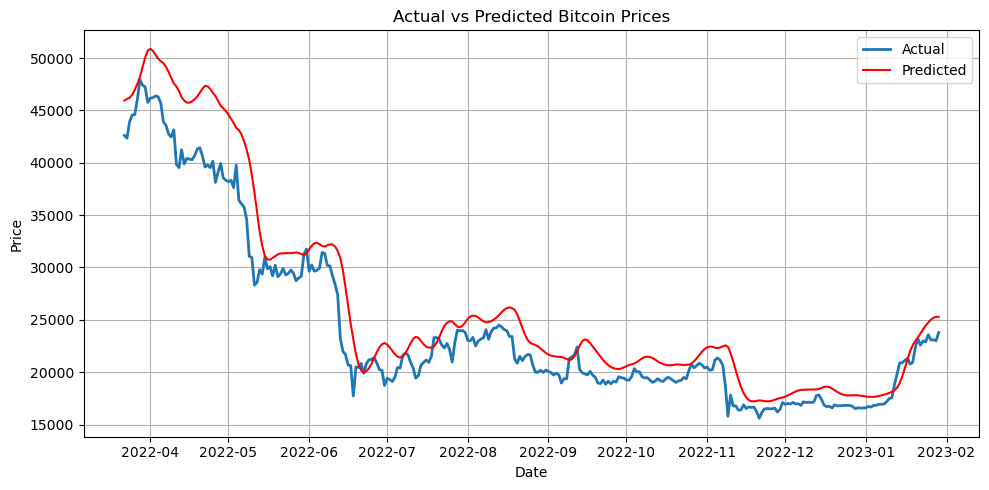

In [ ]:
start_index = 1421 + 120

dates = data_scaled['Date'].iloc[start_index:start_index + len(y_test_orig)].reset_index(drop=True)

# Convert to datetime if not already
dates = pd.to_datetime(dates)

# Plot the actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(dates, y_test_orig, label='Actual', linewidth=2)
plt.plot(dates, y_predict_orig, label='Predicted', color='red')
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()